In [142]:
library(DBI)
library(lda)
library(tidyverse) 
library(tidytext)
library(ggplot2)
library(tm)
library(topicmodels)
library(doParallel)
library(cowplot)
library(gplots)
library(gridExtra)
library(cowplot)
# options(mc.cores = 10) #parallel::detectCores()

Warning message:
“package ‘gplots’ was built under R version 3.6.2”

Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Warning message:
“package ‘gridExtra’ was built under R version 3.6.3”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Package information and useful tutorials

https://cran.r-project.org/web/packages/topicmodels/vignettes/topicmodels.pdf

https://slcladal.github.io/topicmodels.html

didnt use but interesting:
https://cran.r-project.org/web/packages/ldatuning/ldatuning.pdf

In [2]:
# connect to database
con <- DBI::dbConnect(
    RMySQL::MySQL(), 
    host = "localhost",
    user = "uog2000",
    port = 3307,
    dbname = "user_uog2000",
    password = read_file('/home/uog2000/mimir_setup/password.txt') %>% str_replace('\n', '')
)

# Get MH patient data


In [3]:
# has data on the person_id mental health disorder diagnosis
mh_pats <- con %>% tbl('mh_patients')

In [4]:
# has data on the person_id's medical history
# (limited to: top 200 conditions, top 100 procedures, top 100 drug exposures, and MH drug exposures)
mh_dat <- con %>% tbl('mh_all_dat') %>% 
                inner_join(mh_pats, by = 'person_id') %>%
                as_tibble

In [5]:
mh_dat %>% select(-person_id, -date) %>% head()

concept_id,concept_name
<int>,<chr>
967823,Anxiety disorder
967823,Bipolar disorder
967823,Depressive disorder
967823,Anxiety disorder
967823,Bipolar disorder
967823,Depressive disorder


In [6]:
set.seed(0)
sub_patients <- mh_dat %>%
                    distinct(person_id, concept_name) %>%
                    group_by(concept_name) %>%
                    sample_n(3000) %>% ungroup() %>% select(person_id)

In [7]:
# ----- Create dataframe with doc_id and text ------ #
# doc_id is an "doc_x" representing each patient
# text is a combination of all of the concept_ids recorded in the patients medical history
# add separate binary columns for Anxiety, MDD, Bipolar, and post-traumatic stree disorder
mh_dat_subset <- mh_dat %>%
                    inner_join(sub_patients, by = 'person_id') %>%
                    mutate(docid = factor(person_id) %>% as.integer) %>%
                    select(-person_id, -date) %>%
                    mutate(doc_id = paste0('doc_',docid),
                           seen = 1) %>%
                    group_by(doc_id) %>%
                    mutate(text = paste0(concept_id, collapse = " ")) %>%
                    select(doc_id, text, concept_name, seen) %>% distinct() %>%
                    pivot_wider(names_from = 'concept_name', values_from = 'seen', values_fill = list(seen = 0)) %>% 
                    ungroup()

In [8]:
mh_dat_subset %>% distinct(doc_id) %>% dim()

[1] 11149     1

# Create DTM and Corpus

In [9]:
dfCorpus = Corpus(VectorSource(mh_dat_subset$text))  
x_dtm <- DocumentTermMatrix(dfCorpus, control = list(stemming = TRUE, stopwords = TRUE,
                                                     minWordLength = 0, removeNumbers = FALSE,
                                                     removePunctuation = TRUE))
sel_idx <- slam::row_sums(x_dtm) > 0
x_dtm <- x_dtm[sel_idx, ]

In [64]:
str(x_dtm)

List of 6
 $ i       : int [1:843014] 1 1 1 1 1 1 1 1 1 1 ...
 $ j       : int [1:843014] 3 6 7 15 21 25 26 32 38 45 ...
 $ v       : num [1:843014] 18 18 18 9 18 9 27 27 99 9 ...
 $ nrow    : int 11149
 $ ncol    : int 484
 $ dimnames:List of 2
  ..$ Docs : chr [1:11149] "1" "2" "3" "4" ...
  ..$ Terms: chr [1:484] "1000560" "1110410" "1112807" "1112921" ...
 - attr(*, "class")= chr [1:2] "DocumentTermMatrix" "simple_triplet_matrix"
 - attr(*, "weighting")= chr [1:2] "term frequency" "tf"


# Cross Validation Evaluating the Perplexity

- 3 fold cross validation to estimate the loglikelihood and the perplexity of different topic numbers, K

https://stackoverflow.com/questions/21355156/topic-models-cross-validation-with-loglikelihood-or-perplexity
https://stats.stackexchange.com/questions/25113/the-input-parameters-for-using-latent-dirichlet-allocation

In [ ]:
folds <- 3
splitfolds <- sample(1:folds, 10000, replace = TRUE)
candidate_k <- c(2, 4, 6, 8, 10, 12, 15, 20, 25, 30)

In [73]:
ptm <- proc.time()
# count = 0
# r = list()
for(k in c(17)) { # candidate_k){
    for(i in 1:folds){
        count = count + 1
        train_set <- x_dtm[splitfolds != i , ]
        valid_set <- x_dtm[splitfolds == i, ]
        fitted <- LDA(train_set, k = k, method = "VEM", control = list(keep = 10) )
        r[[count]] <- c(k, i, perplexity(fitted, newdata = valid_set), mean(fitted@logLiks))
    }
}
proc.time() - ptm

    user   system  elapsed 
2907.384   17.344 2925.076 

In [75]:
result <- as_tibble(do.call(rbind, r))
colnames(result) <- c('k', 'iter', 'perplexity', 'loglik')

In [76]:
result %>% head()

k,iter,perplexity,loglik
<dbl>,<dbl>,<dbl>,<dbl>
2,1,233.6300,-26021592
2,2,225.5965,-26956572
2,3,233.7491,-27077346
4,1,202.9305,-25211993
4,2,198.9911,-26214351
4,3,200.8295,-26378470


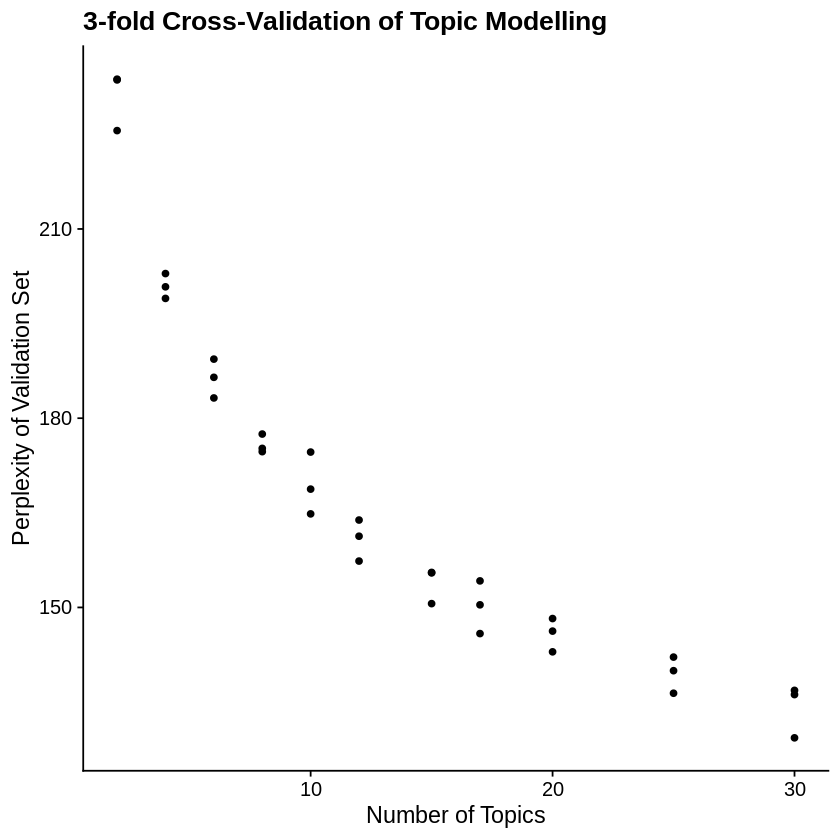

In [145]:
ggplot(result, aes(x = k, y = perplexity)) +
    geom_point() +
    ggtitle("3-fold Cross-Validation of Topic Modelling") +
    labs(x = "Number of Topics", y = "Perplexity of Validation Set") +
    theme_cowplot()


#### Get Concept Mappings

In [11]:
concept_map <- con %>% tbl('concept_maps') %>% as_tibble()
concept_map %>% head()

concept_id,concept_name,vocabulary_id
<int>,<chr>,<chr>
967823,Sodium Chloride,RxNorm
2211327,"Computed tomography, head or brain; without contrast material",CPT4
320128,Essential hypertension,SNOMED
2514436,"Emergency department visit for the evaluation and management of a patient, which requires these 3 key components: A detailed history; A detailed examination; and Medical decision making of moderate complexity. Counseling and/or coordination of care with o",CPT4
2211361,"Radiologic examination, chest, 2 views, frontal and lateral",CPT4
375415,Injury of head,SNOMED


# Table 1: Cohort Description

Creates figures: 
- doc_len.png: The distribution of the number of concepts in patient record
- mh_dist.png: The proportion of patients with each of the four diagnoses

In [88]:
mh_demo <- con %>% tbl('mh_patients_2') %>% as_tibble() %>%
            inner_join(sub_patients, by = 'person_id')
mh_demo %>% colnames()

[1] "person_id" "age"       "is_male"   "race"      "ethnicity"

In [66]:
num_patients = 11149

In [90]:
demodata <- mh_dat %>%
    select(person_id, concept_name) %>%
    inner_join(mh_demo, by = 'person_id') %>%
    mutate(seen = 1) %>% distinct() %>%
    pivot_wider(names_from = 'concept_name', values_from = 'seen', values_fill = list(seen = 0)) %>%
    mutate(total = 1) %>%
    pivot_longer(`Anxiety disorder`:total, names_to = 'group', values_to = 'seen') %>%
    filter(seen == 1) %>%
    group_by(group) %>%
    summarise(n = n(),
              perc = (n/num_patients) * 100,
              median_age = median(age, na.rm = T),
              q_025 = quantile(age, probs = 0.05),
              q_975 = quantile(age, probs = 0.975),
              male = sum(is_male),
              male_perc = (male/n) * 100,
              white = sum(race == 'white'),
              black = sum(race == 'black'),
              asian = sum(race == 'asian'),
              other = sum(race == 'other'),
              missing = sum(race == 'missing'),
              w_p = (white/n)*100,
              c_p = (black/n)*100,
              a_p = (asian/n)*100,
              o_p = (other/n)*100,
              m_p = (missing/n)*100,
              hisp = sum(ethnicity == 'Hispanic'),
              n_hisp = sum(ethnicity == 'Not Hispanic'),
              e_miss = sum(ethnicity == 'missing'),
              h_p = (hisp/n)*100,
              n_h_p = (n_hisp/n)*100,
              e_m_p = (e_miss/n)*100)

`summarise()` ungrouping output (override with `.groups` argument)



In [107]:
demodata %>% 
    rowwise() %>%
    mutate('N (%)' = str_glue('{n} ({round(perc,2)}%)'),
           'Age (95 CI)' = str_glue('{median_age} ({q_025} - {q_975})'),
           'Male (%)' = str_glue('{male} ({round(male_perc,2)})'),
           'Race - Asian (%)' = str_glue('{asian} ({round(a_p,2)}%)'),
           'Race - Black (%)' = str_glue('{black} ({round(c_p,2)}%)'),
           'Race - White (%)' = str_glue('{white} ({round(w_p,2)}%)'),
           'Race - Other (%)' = str_glue('{other} ({round(o_p,2)}%)'),
           'Race - Missing (%)' = str_glue('{missing} ({round(m_p,2)}%)'),
           'Ethnicity - Hispanic (%)' = str_glue('{hisp} ({round(h_p,2)}%)'),
           'Ethnicity - Non-Hispanic (%)' = str_glue('{n_hisp} ({round(n_h_p,2)}%)'),
           'Ethnicity - Missing (%)' = str_glue('{e_miss} ({round(e_m_p,2)}%)'),
          ) %>%
    select(group, 'N (%)':'Ethnicity - Missing (%)') %>% write_csv('mh_demo.csv')

In [124]:
mh_dat %>%
    rename(mh=concept_name) %>%
    inner_join(sub_patients, by = 'person_id') %>%
    inner_join(concept_map, by = 'concept_id') %>%
    group_by(person_id) %>%
    mutate(num_concepts = n(), 
           num_procedures = sum(vocabulary_id == 'CPT4'),
           num_conditions = sum(vocabulary_id == 'SNOMED'),
           num_drugs = sum(vocabulary_id %in% c('ICD9Proc', 'RxNorm'))) %>%
    ungroup() %>%
    select(person_id, mh, starts_with('num')) %>% distinct() %>%
    group_by(mh) %>%
    summarise(mean_concept = mean(num_concepts),
              mean_proc = mean(num_procedures),
              mean_cond = mean(num_conditions), 
              mean_drug = mean(num_drugs),
              sd_concept = sd(num_concepts),
              sd_proc = sd(num_procedures),
              sd_cond = sd(num_conditions),
              sd_drug = sd(num_drugs)) %>%
    mutate_at(`.vars` = vars(-starts_with('mh')), `.funs` = round) %>%
    rowwise() %>% 
    mutate('Number of Concepts' = str_glue('{mean_concept} +/- {sd_concept}'),
           'Number of Procedures' = str_glue('{mean_proc} +/- {sd_proc}'),
           'Number of Conditions' = str_glue('{mean_cond} +/- {sd_cond}'),
           'Number of Medications' = str_glue('{mean_drug} +/- {sd_drug}')) %>%
    select(mh, starts_with('Number')) %>% write_csv('mh_counts.csv')

`summarise()` ungrouping output (override with `.groups` argument)



In [128]:
mh_dat %>%
    rename(mh=concept_name) %>%
    inner_join(sub_patients, by = 'person_id') %>%
    inner_join(concept_map, by = 'concept_id') %>%
    group_by(person_id) %>%
    mutate(num_concepts = n(), 
           num_procedures = sum(vocabulary_id == 'CPT4'),
           num_conditions = sum(vocabulary_id == 'SNOMED'),
           num_drugs = sum(vocabulary_id %in% c('ICD9Proc', 'RxNorm'))) %>%
    ungroup() %>%
    select(person_id, starts_with('num')) %>% distinct() %>%
    summarise(mean_concept = mean(num_concepts),
              mean_proc = mean(num_procedures),
              mean_cond = mean(num_conditions), 
              mean_drug = mean(num_drugs),
              sd_concept = sd(num_concepts),
              sd_proc = sd(num_procedures),
              sd_cond = sd(num_conditions),
              sd_drug = sd(num_drugs)) %>%
    mutate_all(round) %>%
    rowwise() %>% 
    mutate('Number of Concepts' = str_glue('{mean_concept} +/- {sd_concept}'),
           'Number of Procedures' = str_glue('{mean_proc} +/- {sd_proc}'),
           'Number of Conditions' = str_glue('{mean_cond} +/- {sd_cond}'),
           'Number of Medications' = str_glue('{mean_drug} +/- {sd_drug}')) %>%
    select(starts_with('Number'))

Number of Concepts,Number of Procedures,Number of Conditions,Number of Medications
<glue>,<glue>,<glue>,<glue>
1766 +/- 3815,426 +/- 1027,816 +/- 1858,524 +/- 1128


In [62]:
# Number of patients with MH diagnosis
mh_dat_subset %>%
    select(-text) %>%
    pivot_longer(`Anxiety disorder`:`Bipolar disorder`, names_to = 'Diagnosis', values_to = 'seen') %>%
    group_by(Diagnosis) %>%
    summarise(N = sum(seen))

`summarise()` ungrouping output (override with `.groups` argument)



Diagnosis,N
<chr>,<dbl>
Anxiety disorder,8066
Bipolar disorder,4141
Depressive disorder,8259
Posttraumatic stress disorder,3132


In [17]:
# total number of concepts
mh_dat %>%
    inner_join(sub_patients, by = 'person_id') %>% 
    select(-concept_name) %>% distinct() %>%
    nrow()

[1] 2411484

In [21]:
doc_len <- mh_dat %>%
                inner_join(sub_patients, by = 'person_id') %>% 
                select(-concept_name) %>% distinct() %>%
                group_by(person_id) %>%
                summarise(n = n()) %>%
            ggplot(mapping = aes(x = n)) +
                geom_histogram(bins = 50) +
                theme_cowplot() +
                labs(x = 'Concepts in EHR', y = "Number of Patients")
ggsave(filename = 'doc_len.png', plot = doc_len, width =10, height = 10, dpi = 400)

`summarise()` ungrouping output (override with `.groups` argument)



In [25]:
mh_dist <- mh_dat_subset %>% select(-text) %>%
                rename(PTSD=`Posttraumatic stress disorder`) %>%
                pivot_longer(`Anxiety disorder`:`Bipolar disorder`,
                             names_to = 'Diagnosis', values_to = 'seen') %>%
                filter(seen == 1) %>%
            ggplot(mapping = aes(x = Diagnosis)) +
                geom_bar() + 
                scale_y_continuous(name = "Proportion of Patients (%)",
                labels = function(y) (y / 10000) * 100) +
                theme_cowplot() +
                xlab('Mental Health Diagnosis') +
                ylab('Number of Patients')
ggsave(filename = 'mh_dist.png', plot = mh_dist, width = 10, height = 10, dpi = 400)

# Table 2: Feature Description (or figure?)

# Model Training K-performance

Creates figures: 
- Perplexity.png: shows the perplexity for different topic numbers using 3-fold cross validation
- Loglikelihood.png: simlarly shows the loglik for different topic numbers using 3-fold cross validation

# K=4 Figures

- Distribution of topics across MH diagnosis
- Distribution of MH diagnosis across topics
- Top words for the topics


In [29]:
set.seed(0)
K = 4
ptm <- proc.time()
k4_model <- LDA(x_dtm, K, method="VEM", control=list(keep = 10)) 
proc.time() - ptm
# saveRDS(k4_model, 'k4_model.Rds')

In [24]:
k4_results <- posterior(k4_model)

In [27]:
str(k4_results)

List of 2
 $ terms : num [1:4, 1:484] 0.004657 0.0041 0.006397 0.002971 0.000901 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "1" "2" "3" "4"
  .. ..$ : chr [1:484] "1000560" "1110410" "1112807" "1112921" ...
 $ topics: num [1:11149, 1:4] 0.799 0.923 0.59 0.228 0.199 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:11149] "1" "2" "3" "4" ...
  .. ..$ : chr [1:4] "1" "2" "3" "4"


In [36]:
str(k4_model)

Formal class 'LDA_VEM' [package "topicmodels"] with 14 slots
  ..@ alpha          : num 0.132
  ..@ call           : language LDA(x = x_dtm, k = K, method = "VEM", control = list(keep = 10))
  ..@ Dim            : int [1:2] 11149 484
  ..@ control        :Formal class 'LDA_VEMcontrol' [package "topicmodels"] with 13 slots
  .. .. ..@ estimate.alpha: logi TRUE
  .. .. ..@ alpha         : num 12.5
  .. .. ..@ seed          : int 1608244629
  .. .. ..@ verbose       : int 0
  .. .. ..@ prefix        : chr "/tmp/RtmpW7MTFI/file6b0f7cb79e31"
  .. .. ..@ save          : int 0
  .. .. ..@ nstart        : int 1
  .. .. ..@ best          : logi TRUE
  .. .. ..@ keep          : int 10
  .. .. ..@ estimate.beta : logi TRUE
  .. .. ..@ var           :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.max: int 500
  .. .. .. .. ..@ tol     : num 1e-06
  .. .. ..@ em            :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.m

In [133]:
terms(k4_model, 4) %>% as_tibble() %>%
    pivot_longer(cols = starts_with('Topic'), names_to = 'topic', values_to = 'concept_id') %>%
    mutate(concept_id = concept_id %>% as.integer()) %>%
    inner_join(concept_map, by = 'concept_id') %>%
    arrange(topic)

topic,concept_id,concept_name,vocabulary_id
<chr>,<int>,<chr>,<chr>
Topic 1,320128,Essential hypertension,SNOMED
Topic 1,2414398,"Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: A detailed history; A detailed examination; Medical decision making of moderate complexity. Counseling and/o",CPT4
Topic 1,2414397,"Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: An expanded problem focused history; An expanded problem focused examination; Medical decision making of low",CPT4
Topic 1,194133,Low back pain,SNOMED
Topic 2,2514408,"Subsequent hospital care, per day, for the evaluation and management of a patient, which requires at least 2 of these 3 key components: An expanded problem focused interval history; An expanded problem focused examination; Medical decision making of moder",CPT4
Topic 2,2514409,"Subsequent hospital care, per day, for the evaluation and management of a patient, which requires at least 2 of these 3 key components: A detailed interval history; A detailed examination; Medical decision making of high complexity. Counseling and/or coor",CPT4
Topic 2,319835,Congestive heart failure,SNOMED
Topic 2,2211359,"Radiologic examination, chest; single view, frontal",CPT4
Topic 3,2514435,"Emergency department visit for the evaluation and management of a patient, which requires these 3 key components: An expanded problem focused history; An expanded problem focused examination; and Medical decision making of moderate complexity. Counseling",CPT4


In [18]:
beta <- k4_results$terms   # get beta from results
theta <- k4_results$topics 
colnames(theta) <- paste0('k', 1:4)

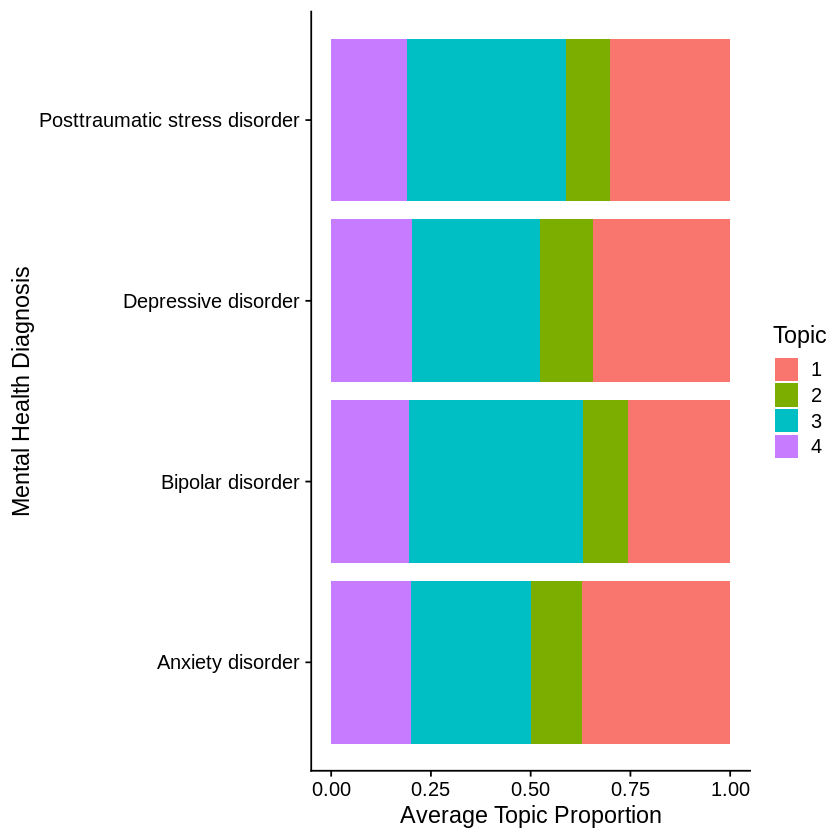

In [132]:
k4_mh_dis <- k4_results$topics %>% as_tibble %>%
                rename(k1=`1`, k2 = `2`, k3 = `3`, k4 = `4`) %>%
                mutate(doc_id = paste0('doc_', row_number())) %>%
                relocate(doc_id, `.before` = 'k1') %>%
                inner_join(mh_dat_subset %>% select(-text), by = 'doc_id') %>%
                pivot_longer(`Anxiety disorder`:`Bipolar disorder`, names_to = 'mh_diag', values_to = 'seen') %>%
                filter(seen == 1) %>%
                group_by(mh_diag) %>%
                summarise_at(vars('k1':'k4'), mean) %>%
                pivot_longer(k1:k4, names_to = 'Topic', values_to = 'avg_theta', names_prefix = 'k') %>%
            ggplot(mapping = aes(x = mh_diag, y = avg_theta, fill = Topic)) +
                geom_bar(stat = 'identity') +
                theme_cowplot() +
                xlab('Mental Health Diagnosis') +
                ylab('Average Topic Proportion') + 
                coord_flip()
k4_mh_dis
ggsave(filename = 'k4_mh_dist.png', plot = k4_mh_dis, width =10, height = 10, dpi = 400)

`summarise()` regrouping output by 'topic' (override with `.groups` argument)



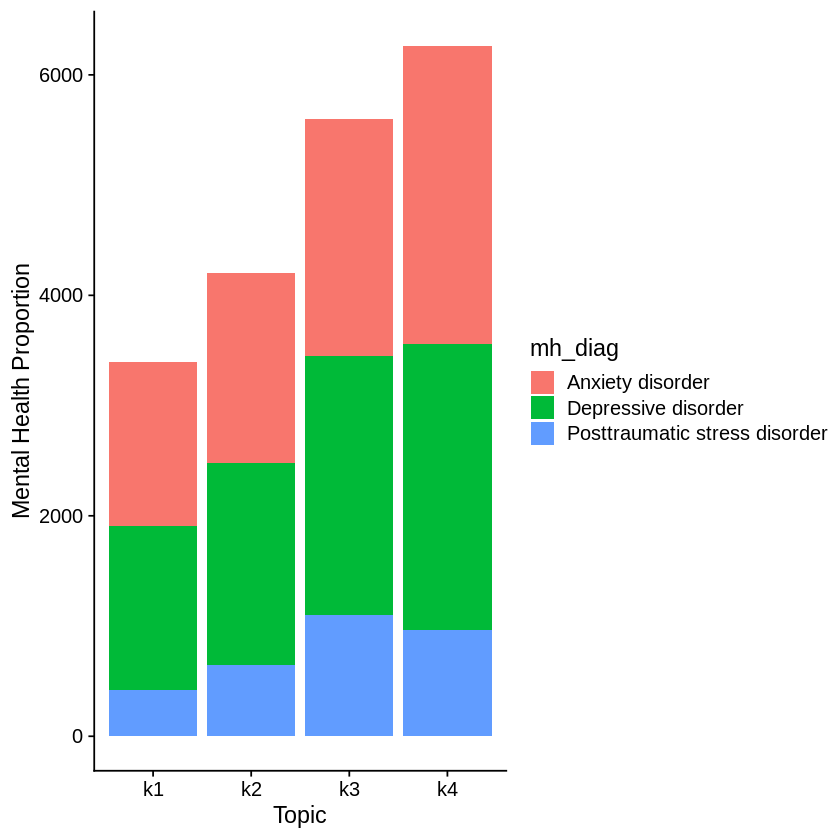

In [24]:
theta %>% as_tibble %>%
    mutate(doc_id = paste0('doc_', row_number())) %>%
    relocate(doc_id, `.before` = 'k1') %>%
    inner_join(mh_dat_subset %>% select(-text), by = 'doc_id') %>%
    pivot_longer(`Anxiety disorder`:`Posttraumatic stress disorder`, names_to = 'mh_diag', values_to = 'seen') %>%
    filter(seen == 1) %>%
    pivot_longer(k1:k4, names_to = 'topic', values_to = 'theta') %>%
    group_by(topic, mh_diag) %>%
    summarise(avg_theta = sum(theta)) %>%
ggplot(mapping = aes(x = topic, y = avg_theta, fill = mh_diag)) +
    geom_bar(stat = 'identity') +
    theme_cowplot() +
    xlab('Topic') +
    ylab('Mental Health Proportion')

# Co-occurrence heatmap of the words

# K = 9 Performance

In [37]:
set.seed(0)
K = 9
ptm <- proc.time()
k9_model <- LDA(x_dtm, K, method="VEM", control=list(keep = 10)) 
proc.time() - ptm

   user  system elapsed 
584.956   0.932 585.957 

In [38]:
k9_results <- posterior(k9_model)
str(k9_results)

List of 2
 $ terms : num [1:9, 1:484] 0.000315 0.015857 0.003205 0.004844 0.006762 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:9] "1" "2" "3" "4" ...
  .. ..$ : chr [1:484] "1000560" "1110410" "1112807" "1112921" ...
 $ topics: num [1:11149, 1:9] 3.09e-02 2.15e-05 2.75e-05 2.24e-01 1.61e-04 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:11149] "1" "2" "3" "4" ...
  .. ..$ : chr [1:9] "1" "2" "3" "4" ...


In [40]:
k9_results$topics %>% as_tibble %>% head()

1,2,3,4,5,6,7,8,9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.087221e-02,0.11167650,1.520116e-02,1.382648e-01,7.510523e-05,7.511256e-05,5.736615e-01,5.922950e-02,0.0709440549
2.146915e-05,0.02470997,2.146934e-05,2.147325e-05,2.146934e-05,2.146860e-05,9.259783e-01,4.918295e-02,0.0000214679
2.754713e-05,0.10421039,2.755177e-05,5.674771e-01,2.754926e-05,2.386440e-01,2.755002e-05,2.755054e-05,0.0895307914
2.242347e-01,0.01858562,1.515582e-05,6.698900e-02,1.515416e-05,2.242408e-01,8.742329e-02,1.175546e-01,0.2609417056
1.611253e-04,0.18565205,1.538898e-01,6.962675e-02,1.611374e-04,3.270283e-01,1.159952e-01,7.901853e-02,0.0684671280
6.950322e-05,0.02114729,2.655592e-01,6.950867e-05,6.950639e-05,3.167708e-01,2.195125e-02,3.226631e-01,0.0516999574


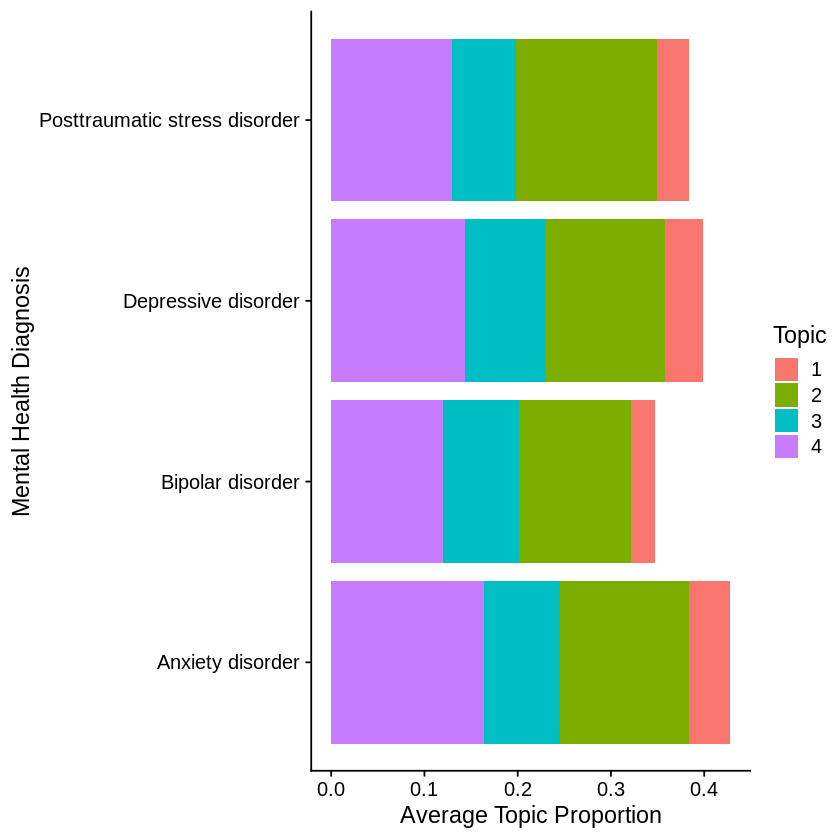

In [42]:
k9_mh_dis <- k9_results$topics %>% as_tibble %>%
                mutate(doc_id = paste0('doc_', row_number())) %>%
                relocate(doc_id, `.before` = '1') %>%
                inner_join(mh_dat_subset %>% select(-text), by = 'doc_id') %>%
                pivot_longer(`Anxiety disorder`:`Bipolar disorder`, names_to = 'mh_diag', values_to = 'seen') %>%
                filter(seen == 1) %>%
                group_by(mh_diag) %>%
                summarise_at(vars('1':'9'), mean) %>%
                pivot_longer(`1`:`4`, names_to = 'Topic', values_to = 'avg_theta', names_prefix = 'k') %>%
            ggplot(mapping = aes(x = mh_diag, y = avg_theta, fill = Topic)) +
                geom_bar(stat = 'identity') +
                theme_cowplot() +
                xlab('Mental Health Diagnosis') +
                ylab('Average Topic Proportion') + 
                coord_flip()
k9_mh_dis
# ggsave(filename = 'k4_mh_dist.png', plot = k4_mh_dis, width =10, height = 10, dpi = 400)

In [147]:
terms(k9_model, 4) %>% as_tibble() %>%
    pivot_longer(cols = starts_with('Topic'), names_to = 'topic', values_to = 'concept_id') %>%
    mutate(concept_id = concept_id %>% as.integer()) %>%
    inner_join(concept_map, by = 'concept_id') %>%
    arrange(topic)

topic,concept_id,concept_name,vocabulary_id
<chr>,<int>,<chr>,<chr>
Topic 1,319835,Congestive heart failure,SNOMED
Topic 1,313217,Atrial fibrillation,SNOMED
Topic 1,77670,Chest pain,SNOMED
Topic 1,316139,Heart failure,SNOMED
Topic 2,200219,Abdominal pain,SNOMED
Topic 2,2514436,"Emergency department visit for the evaluation and management of a patient, which requires these 3 key components: A detailed history; A detailed examination; and Medical decision making of moderate complexity. Counseling and/or coordination of care with o",CPT4
Topic 2,2514437,"Emergency department visit for the evaluation and management of a patient, which requires these 3 key components within the constraints imposed by the urgency of the patient's clinical condition and/or mental status: A comprehensive history; A comprehensi",CPT4
Topic 2,967823,Sodium Chloride,RxNorm
Topic 3,2514408,"Subsequent hospital care, per day, for the evaluation and management of a patient, which requires at least 2 of these 3 key components: An expanded problem focused interval history; An expanded problem focused examination; Medical decision making of moder",CPT4


# K = 12 Performance

- look into top words

In [55]:
set.seed(0)
K = 12
ptm <- proc.time()
k12_model <- LDA(x_dtm, K, method="VEM", control=list(keep = 10, alpha = 0.2)) 
proc.time() - ptm

    user   system  elapsed 
1119.844    1.904 1121.844 

In [56]:
str(k12_model)

Formal class 'LDA_VEM' [package "topicmodels"] with 14 slots
  ..@ alpha          : num 0.0916
  ..@ call           : language LDA(x = x_dtm, k = K, method = "VEM", control = list(keep = 10, alpha = 0.2))
  ..@ Dim            : int [1:2] 11149 484
  ..@ control        :Formal class 'LDA_VEMcontrol' [package "topicmodels"] with 13 slots
  .. .. ..@ estimate.alpha: logi TRUE
  .. .. ..@ alpha         : num 0.2
  .. .. ..@ seed          : int 1608249701
  .. .. ..@ verbose       : int 0
  .. .. ..@ prefix        : chr "/tmp/RtmpW7MTFI/file6b0f39397961"
  .. .. ..@ save          : int 0
  .. .. ..@ nstart        : int 1
  .. .. ..@ best          : logi TRUE
  .. .. ..@ keep          : int 10
  .. .. ..@ estimate.beta : logi TRUE
  .. .. ..@ var           :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.max: int 500
  .. .. .. .. ..@ tol     : num 1e-06
  .. .. ..@ em            :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. 

In [57]:
k12_results <- posterior(k12_model)

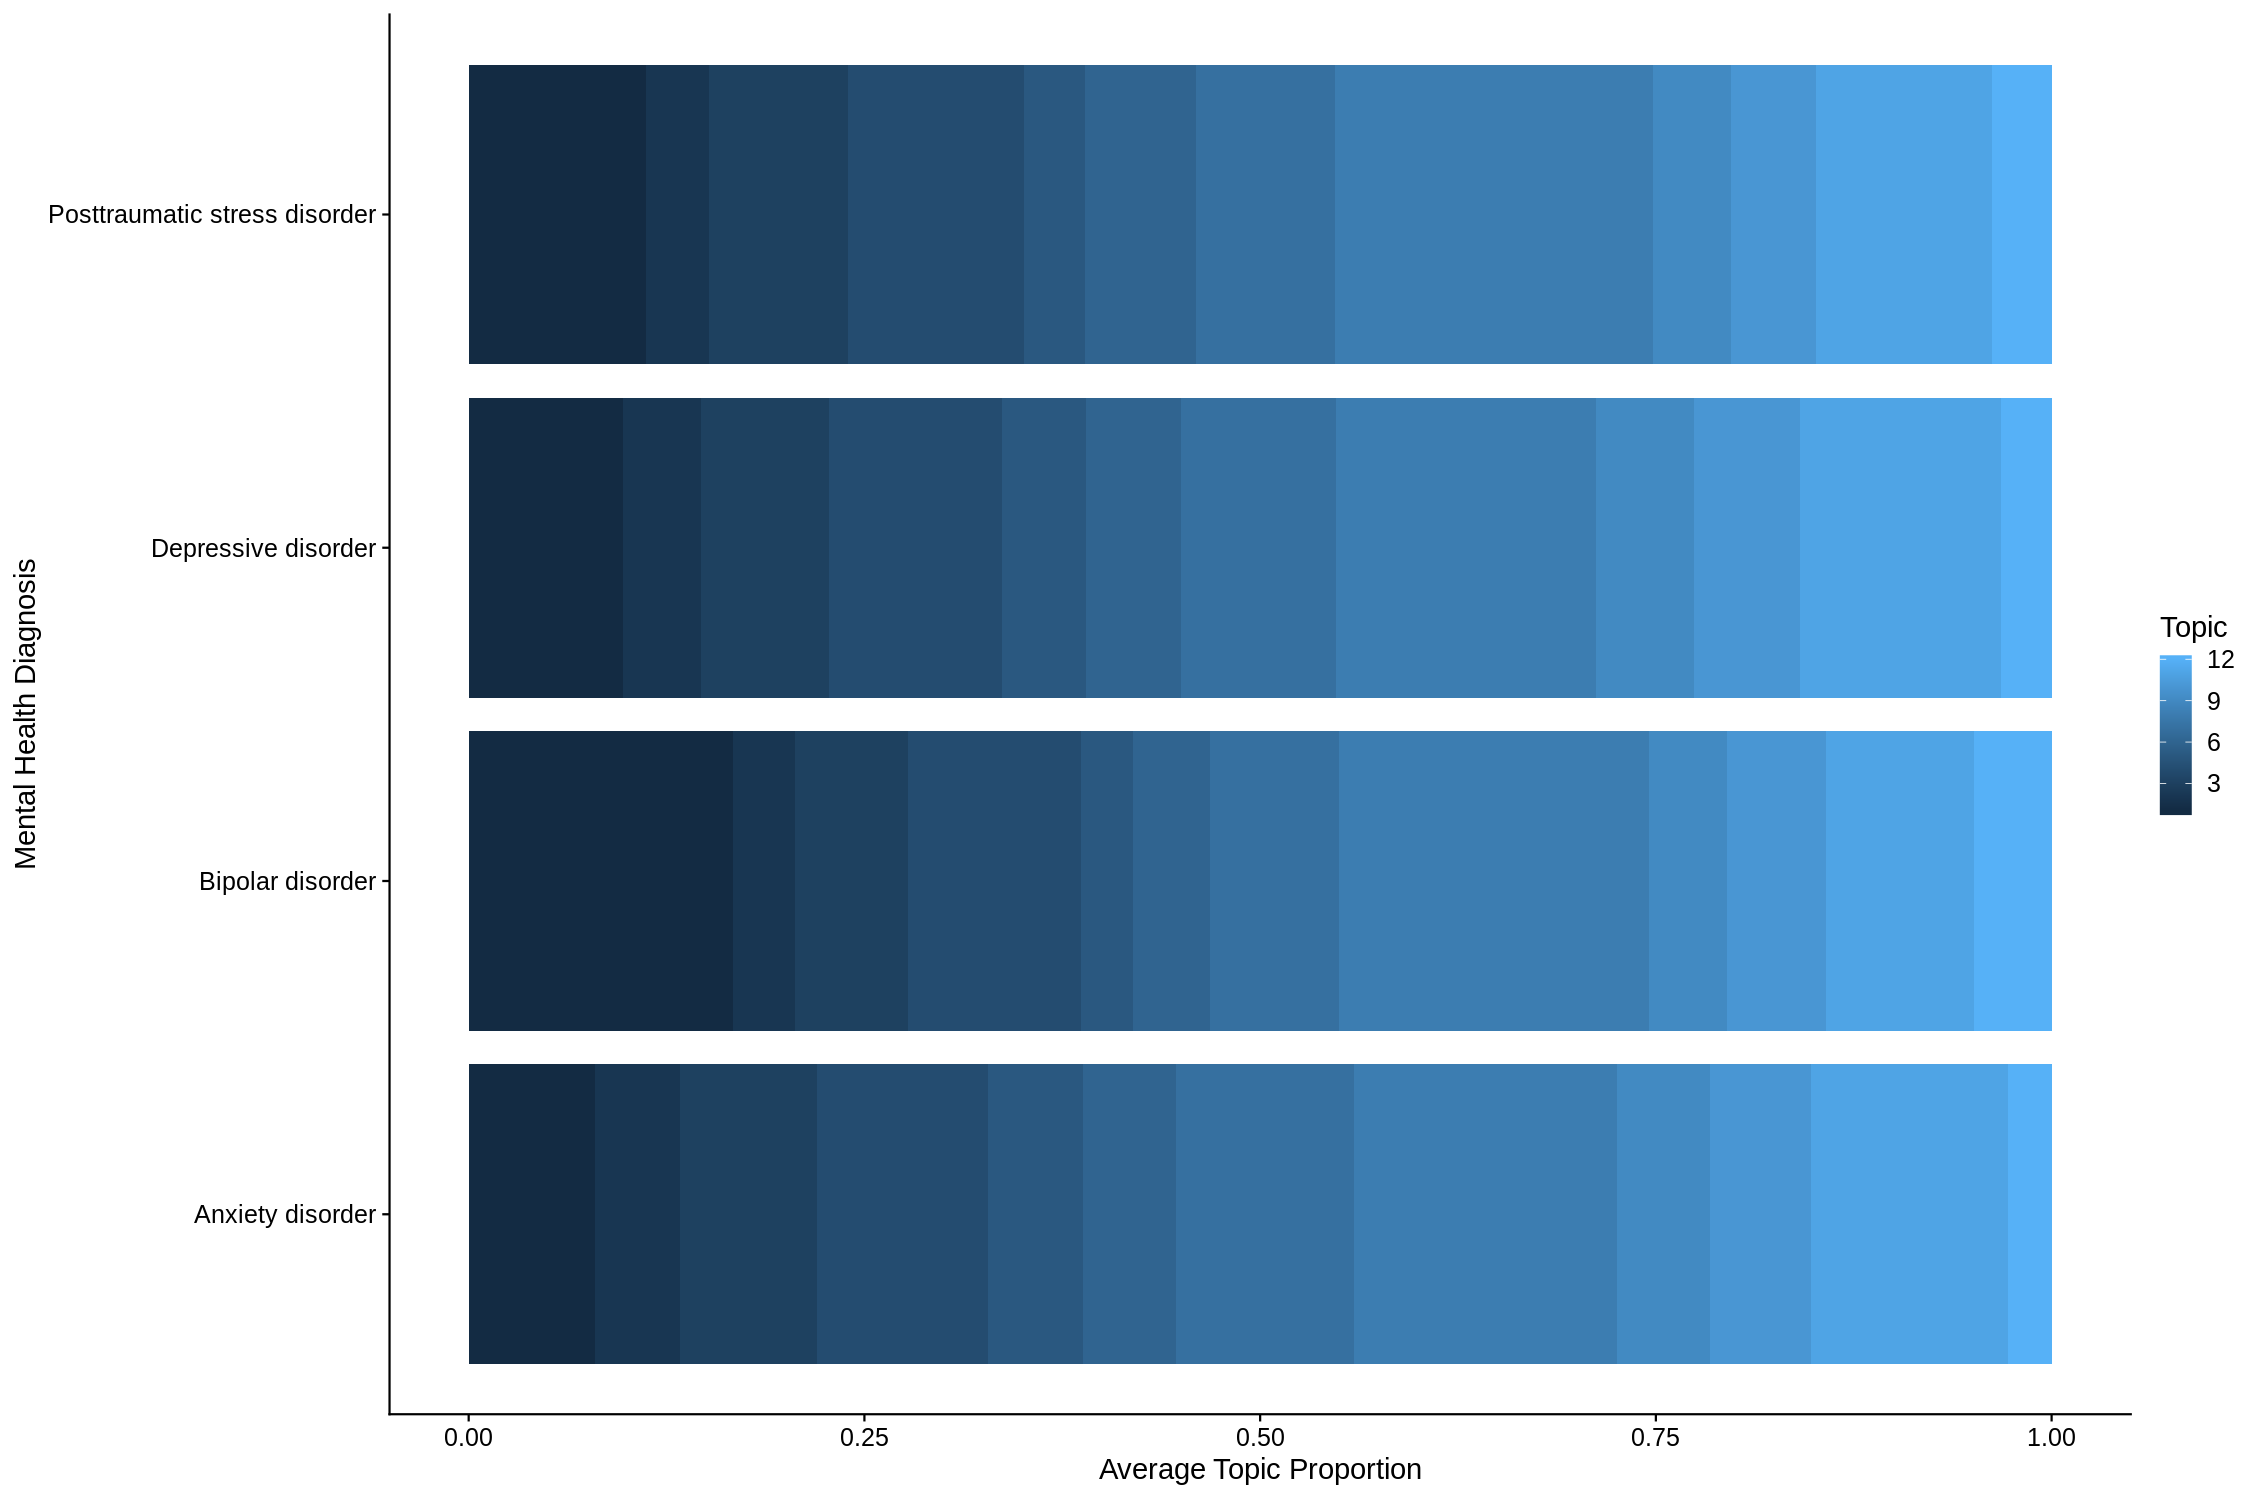

In [155]:
k12_mh_dis <- k12_results$topics %>% as_tibble %>%
                mutate(doc_id = paste0('doc_', row_number())) %>%
                relocate(doc_id, `.before` = '1') %>%
                inner_join(mh_dat_subset %>% select(-text), by = 'doc_id') %>%
                pivot_longer(`Anxiety disorder`:`Bipolar disorder`, names_to = 'mh_diag', values_to = 'seen') %>%
                filter(seen == 1) %>%
                group_by(mh_diag) %>%
                summarise_at(vars('1':'12'), mean) %>%
                pivot_longer(`1`:`12`, names_to = 'Topic', values_to = 'avg_theta') %>%
                mutate(Topic = Topic %>% as.integer()) %>%
            ggplot(mapping = aes(x = mh_diag, y = avg_theta, fill = Topic)) +
                geom_bar(stat = 'identity') +
                theme_cowplot() +
                xlab('Mental Health Diagnosis') +
                ylab('Average Topic Proportion') + 
                coord_flip()
k12_mh_dis
# ggsave(filename = 'k12_mh_dist.png', plot = k4_mh_dis, width =10, height = 10, dpi = 400)

`summarise()` regrouping output by 'topic' (override with `.groups` argument)



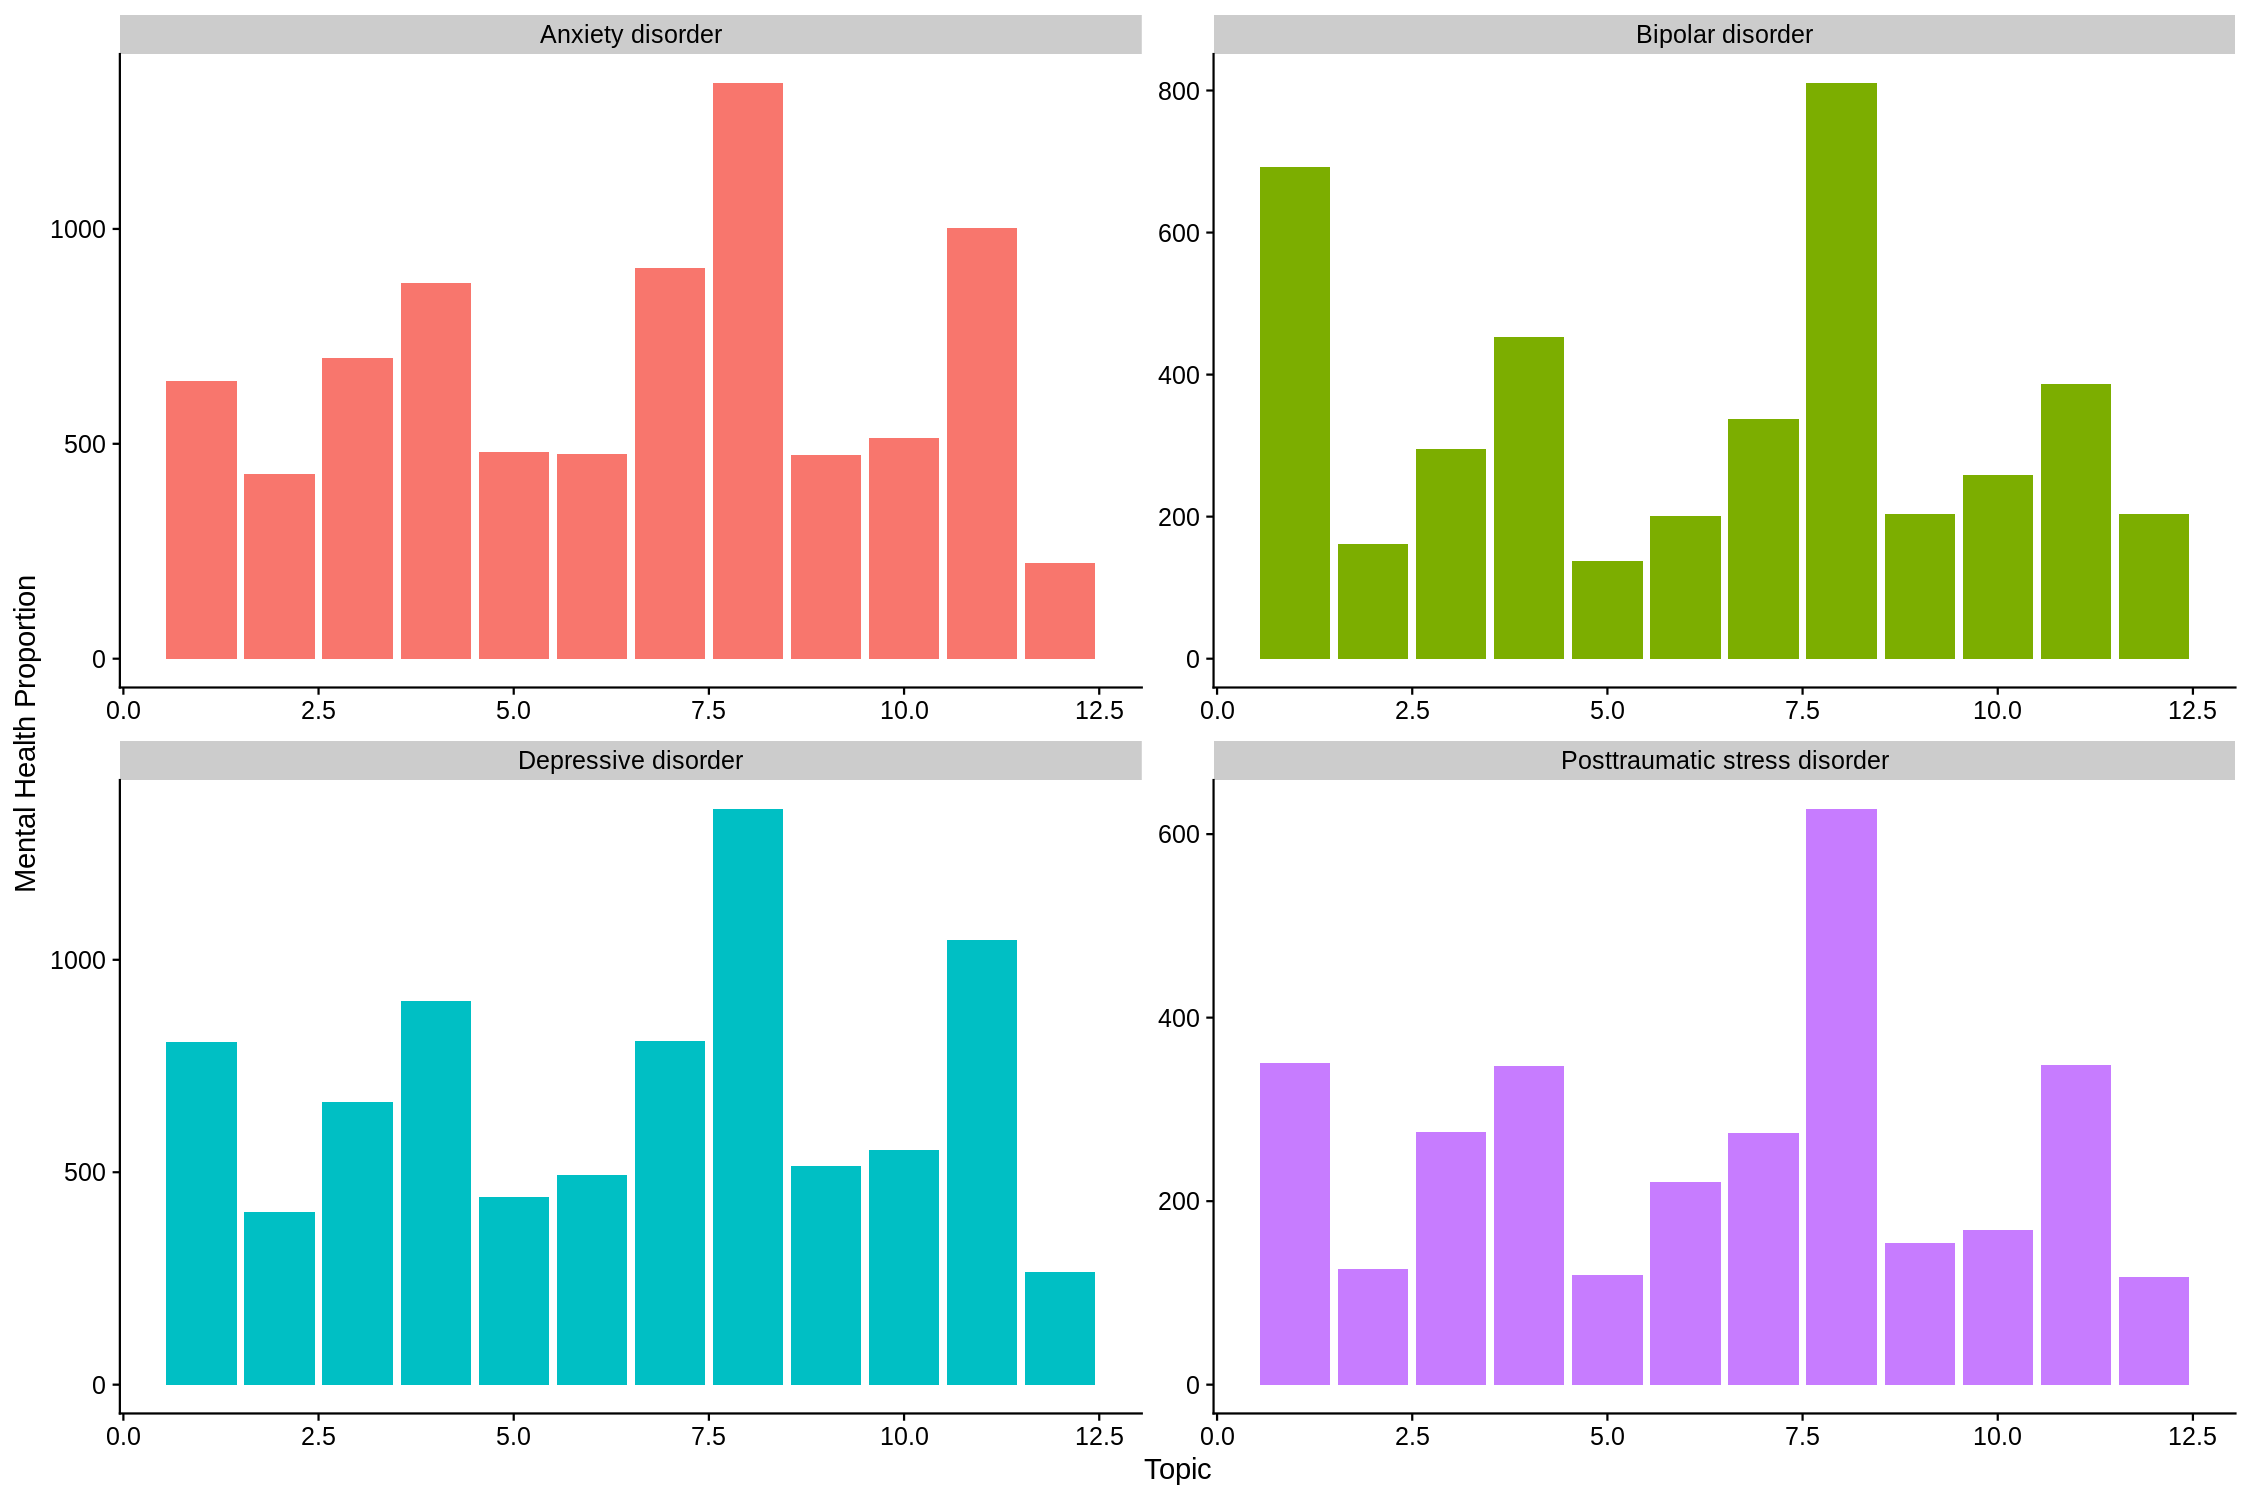

In [159]:
mh_12_dist <- k12_results$topics %>% as_tibble %>%
    mutate(doc_id = paste0('doc_', row_number())) %>%
    relocate(doc_id, `.before` = '1') %>%
    inner_join(mh_dat_subset %>% select(-text), by = 'doc_id') %>%
    pivot_longer(`Anxiety disorder`:`Bipolar disorder`, names_to = 'mh_diag', values_to = 'seen') %>%
    filter(seen == 1) %>%
    pivot_longer(`1`:`12`, names_to = 'topic', values_to = 'theta') %>%
    mutate(topic = topic %>% as.integer()) %>%
    group_by(topic, mh_diag) %>%
    summarise(avg_theta = sum(theta)) %>%
ggplot(mapping = aes(x = topic, y = avg_theta, fill = mh_diag)) +
    geom_bar(stat = 'identity') +
    theme_cowplot() +
    theme(legend.position = "None") +
    xlab('Topic') +
    ylab('Mental Health Proportion') +
    facet_wrap(~mh_diag, scales = 'free')
mh_12_dist

In [148]:
terms(k12_model, 4) %>% as_tibble() %>%
    pivot_longer(cols = starts_with('Topic'), names_to = 'topic', values_to = 'concept_id') %>%
    mutate(concept_id = concept_id %>% as.integer()) %>%
    inner_join(concept_map, by = 'concept_id') %>%
    arrange(topic)

topic,concept_id,concept_name,vocabulary_id
<chr>,<int>,<chr>,<chr>
Topic 1,2514408,"Subsequent hospital care, per day, for the evaluation and management of a patient, which requires at least 2 of these 3 key components: An expanded problem focused interval history; An expanded problem focused examination; Medical decision making of moder",CPT4
Topic 1,4273391,Suicidal thoughts,SNOMED
Topic 1,444100,Mood disorder,SNOMED
Topic 1,436073,Psychotic disorder,SNOMED
Topic 10,320128,Essential hypertension,SNOMED
Topic 10,4008576,Diabetes mellitus without complication,SNOMED
Topic 10,4193704,Type 2 diabetes mellitus without complication,SNOMED
Topic 10,432867,Hyperlipidemia,SNOMED
Topic 11,194133,Low back pain,SNOMED


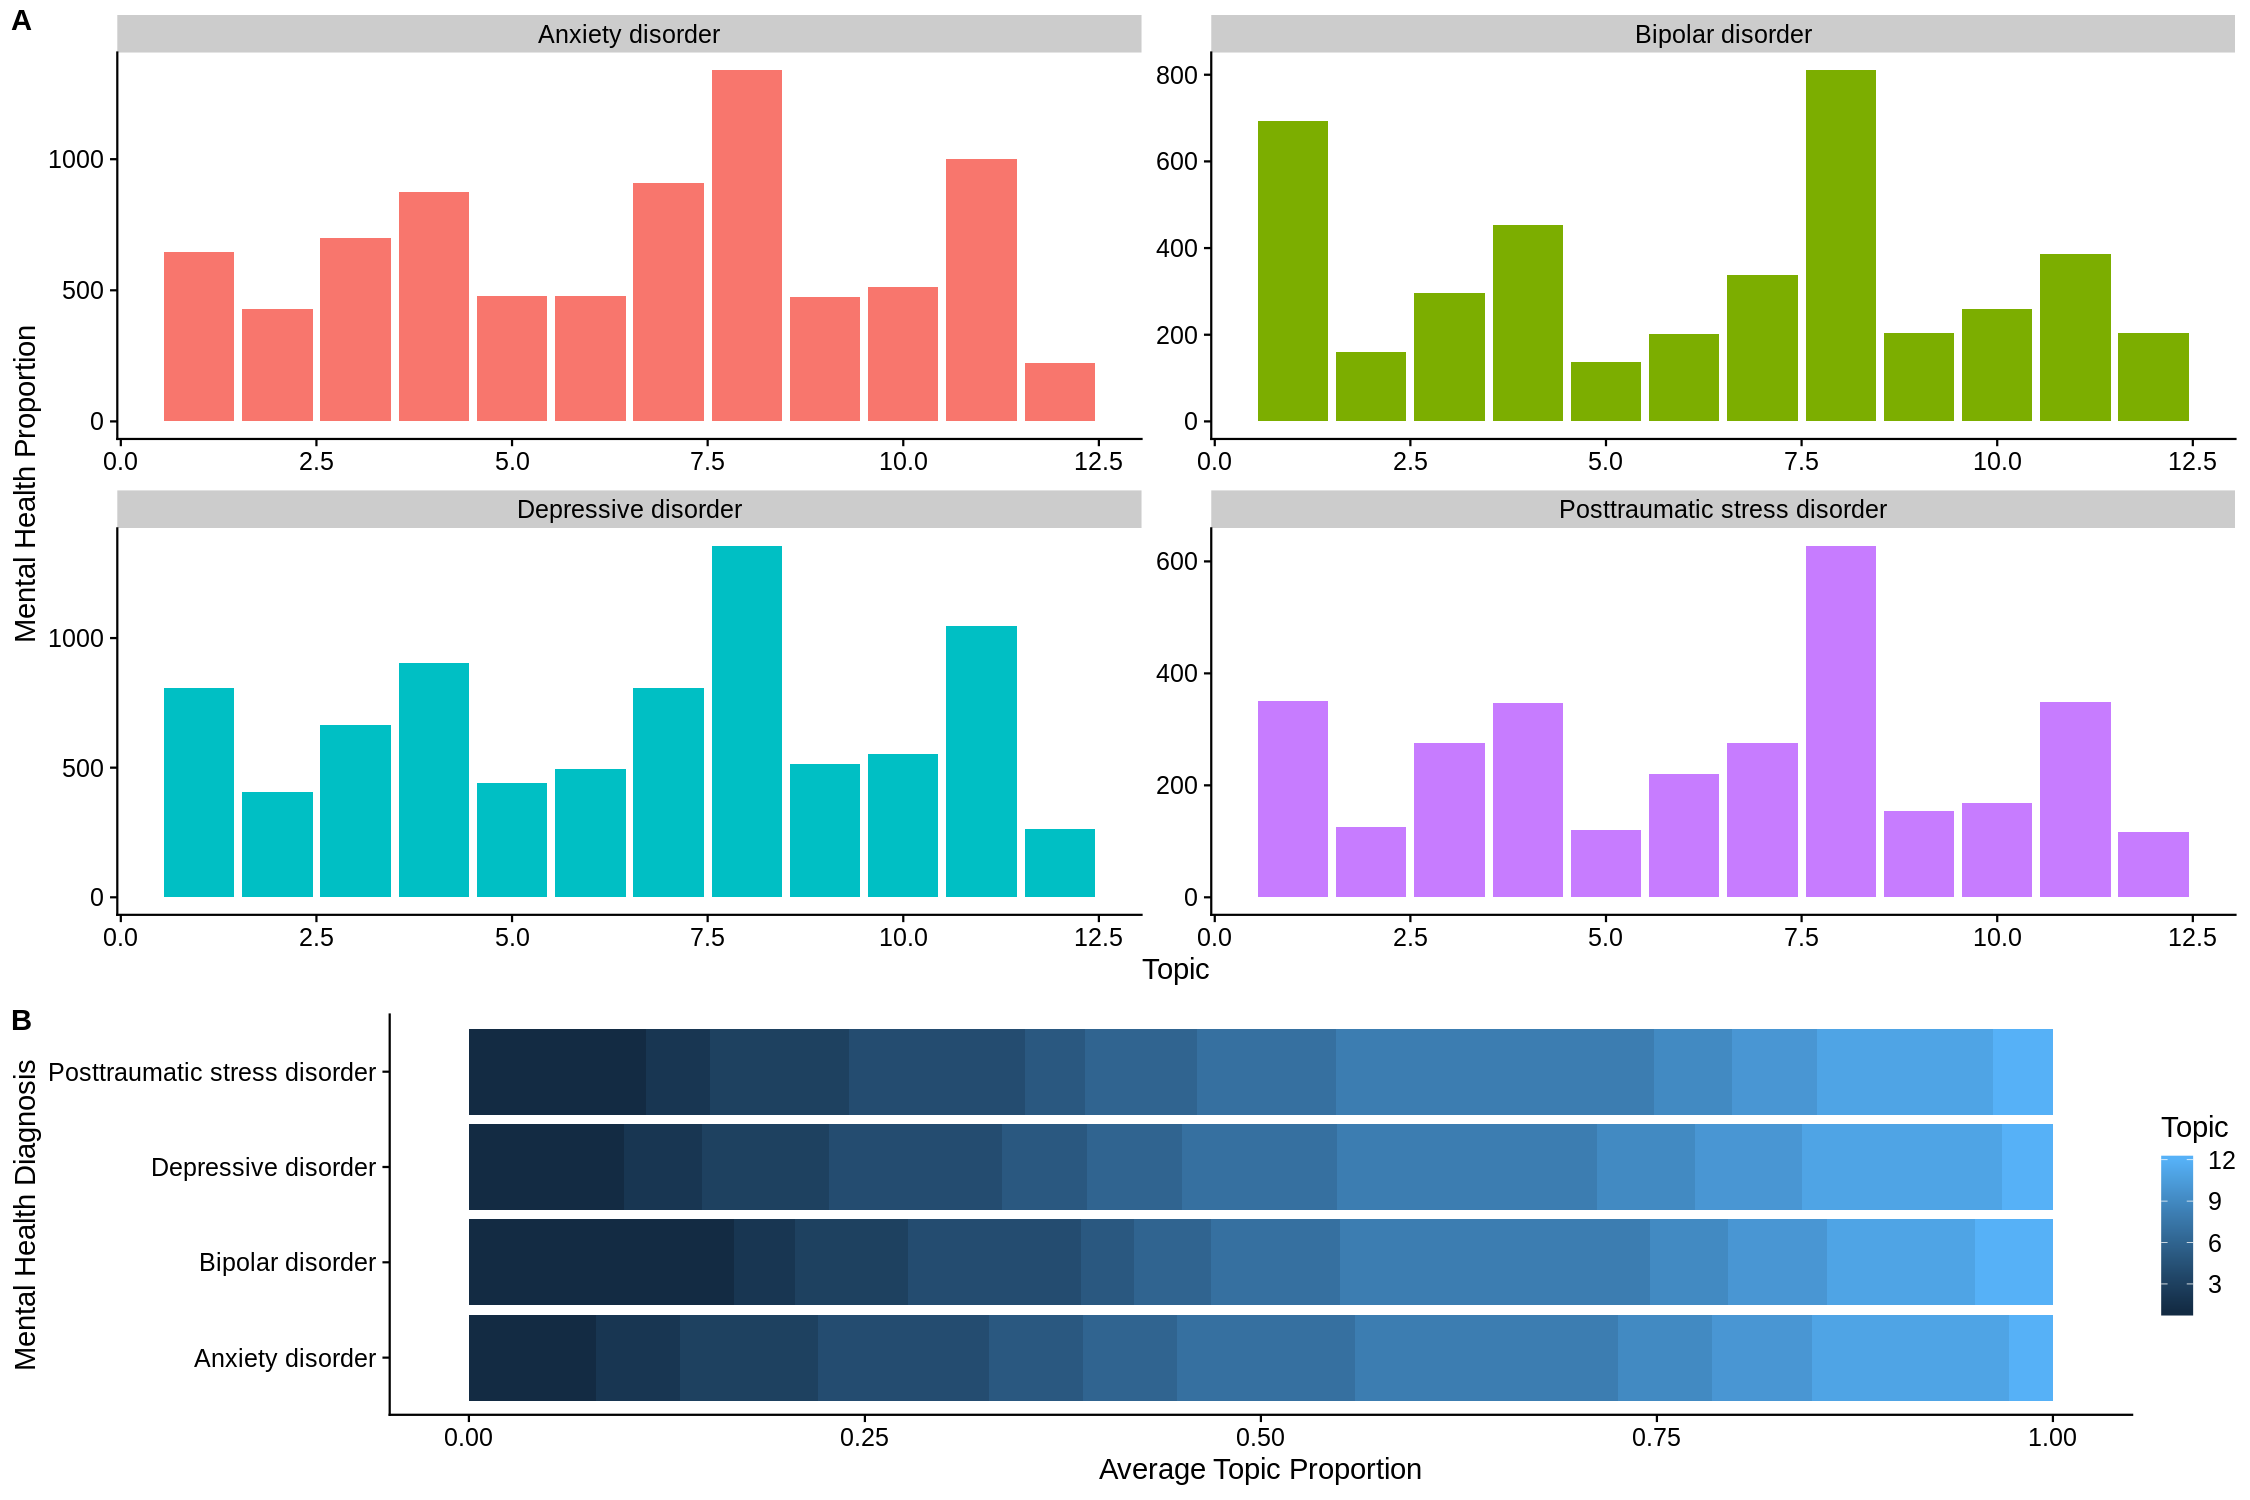

In [160]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 150)
leftcol <- plot_grid(
    mh_12_dist, 
    k12_mh_dis,
    labels = c('A', 'B'),
    rel_heights = c(1, 0.5),
    ncol = 1
)

leftcol
ggsave('k12_results.png', leftcol, width =10, height = 10, dpi = 400)